In [147]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from matplotlib.dates import DateFormatter
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from prophet import Prophet
import seaborn as sns
import pandas as pd
import numpy as np
import warnings

plt.style.use('dark_background')
np.random.seed(1000000000)


In [148]:
df = pd.read_csv('_data/DataSet_Tesco5000_withDaynum.csv')
print(df.head())

   customer_id  visit_date  visit_spend  daynum
0            2  2010-04-01         5.97       0
1            2  2010-04-06        12.71       5
2            2  2010-04-07        34.52       6
3            2  2010-04-12         7.89      11
4            2  2010-04-14        17.17      13


In [149]:
print(df.describe())

         customer_id    visit_spend         daynum
count  596733.000000  596733.000000  596733.000000
mean     3767.274035      44.959696     220.899340
std      2095.613007      43.002075     128.829448
min         2.000000       0.000000       0.000000
25%      2022.000000      13.000000     109.000000
50%      3792.000000      32.780000     220.000000
75%      5560.000000      64.170000     333.000000
max      7376.000000    1234.000000     444.000000


# Data Preprocess

In [150]:
# first lets convert just in case
df['visit_date'] = pd.to_datetime(df['visit_date'])
# then we aggregate the daily incomes by date
daily_sales = df.groupby('visit_date')['visit_spend'].sum().reset_index()
# then we must sort them cause this is a time series task
daily_sales = daily_sales.sort_values('visit_date')
# then we add a dayofwekk for easier forecasting later
daily_sales['dayofweek'] = daily_sales['visit_date'].dt.dayofweek
print(daily_sales.head(20))

   visit_date  visit_spend  dayofweek
0  2010-04-01    102625.86          3
1  2010-04-02     82660.90          4
2  2010-04-03     78081.71          5
3  2010-04-04      4411.05          6
4  2010-04-05     38144.77          0
5  2010-04-06     52928.27          1
6  2010-04-07     53908.71          2
7  2010-04-08     70863.75          3
8  2010-04-09     80590.71          4
9  2010-04-10     75106.49          5
10 2010-04-11     32378.62          6
11 2010-04-12     52254.00          0
12 2010-04-13     49675.77          1
13 2010-04-14     55140.20          2
14 2010-04-15     73373.36          3
15 2010-04-16     82873.34          4
16 2010-04-17     73813.13          5
17 2010-04-18     37063.13          6
18 2010-04-19     51794.76          0
19 2010-04-20     49453.42          1


In [151]:
print(f"Start: {daily_sales['visit_date'].min()}")
print(f"End: {daily_sales['visit_date'].max()}")
print(daily_sales.shape)

Start: 2010-04-01 00:00:00
End: 2011-06-19 00:00:00
(444, 3)


Tehát 2010-04-01-től 2011-06-19-ig van 444 megfigyelésünk.

In [152]:
daily_sales['visit_spend'].describe()

count       444.000000
mean      60425.527027
std       18117.753079
min        4411.050000
25%       48790.375000
50%       54932.530000
75%       76248.940000
max      119242.070000
Name: visit_spend, dtype: float64

Nézzük meg van-e hiányzó dátum.

In [153]:
date_range = pd.date_range(start=daily_sales['visit_date'].min(),
                          end=daily_sales['visit_date'].max())
missing_dates = set(date_range) - set(daily_sales['visit_date'])
print("\nNumber of missing dates:", len(missing_dates))
if len(missing_dates) > 0:
    print("Sample of missing dates:")
    print(sorted(list(missing_dates))[:5])


Number of missing dates: 1
Sample of missing dates:
[Timestamp('2010-12-25 00:00:00')]


Most kitöltöm egy átlaggal, de operacionizálásnál erre nyílván figyelni kellene hogy itt a modellünk nem fog megbízható eredményt adni.

In [154]:
# there's only one ofc
missing_date = sorted(list(missing_dates))[0]
day_before = missing_date - pd.Timedelta(days=1)
day_after = missing_date + pd.Timedelta(days=1)
before_value = daily_sales[daily_sales['visit_date'] == day_before]['visit_spend'].values[0]
after_value = daily_sales[daily_sales['visit_date'] == day_after]['visit_spend'].values[0]

imputed_value = (before_value + after_value) / 2

new_row = pd.DataFrame({
    'visit_date': [missing_date],
    'visit_spend': [imputed_value],
    'dayofweek': [missing_date.dayofweek]
})

# add new row then sort then reindex
daily_sales = pd.concat([daily_sales, new_row], ignore_index=True)
daily_sales = daily_sales.sort_values('visit_date').reset_index(drop=True)

print("Values around the imputed date:")
print(daily_sales[daily_sales['visit_date'].isin([day_before, missing_date, day_after])])

Values around the imputed date:
    visit_date  visit_spend  dayofweek
267 2010-12-24     56986.23          4
268 2010-12-25     33081.07          5
269 2010-12-26      9175.91          6


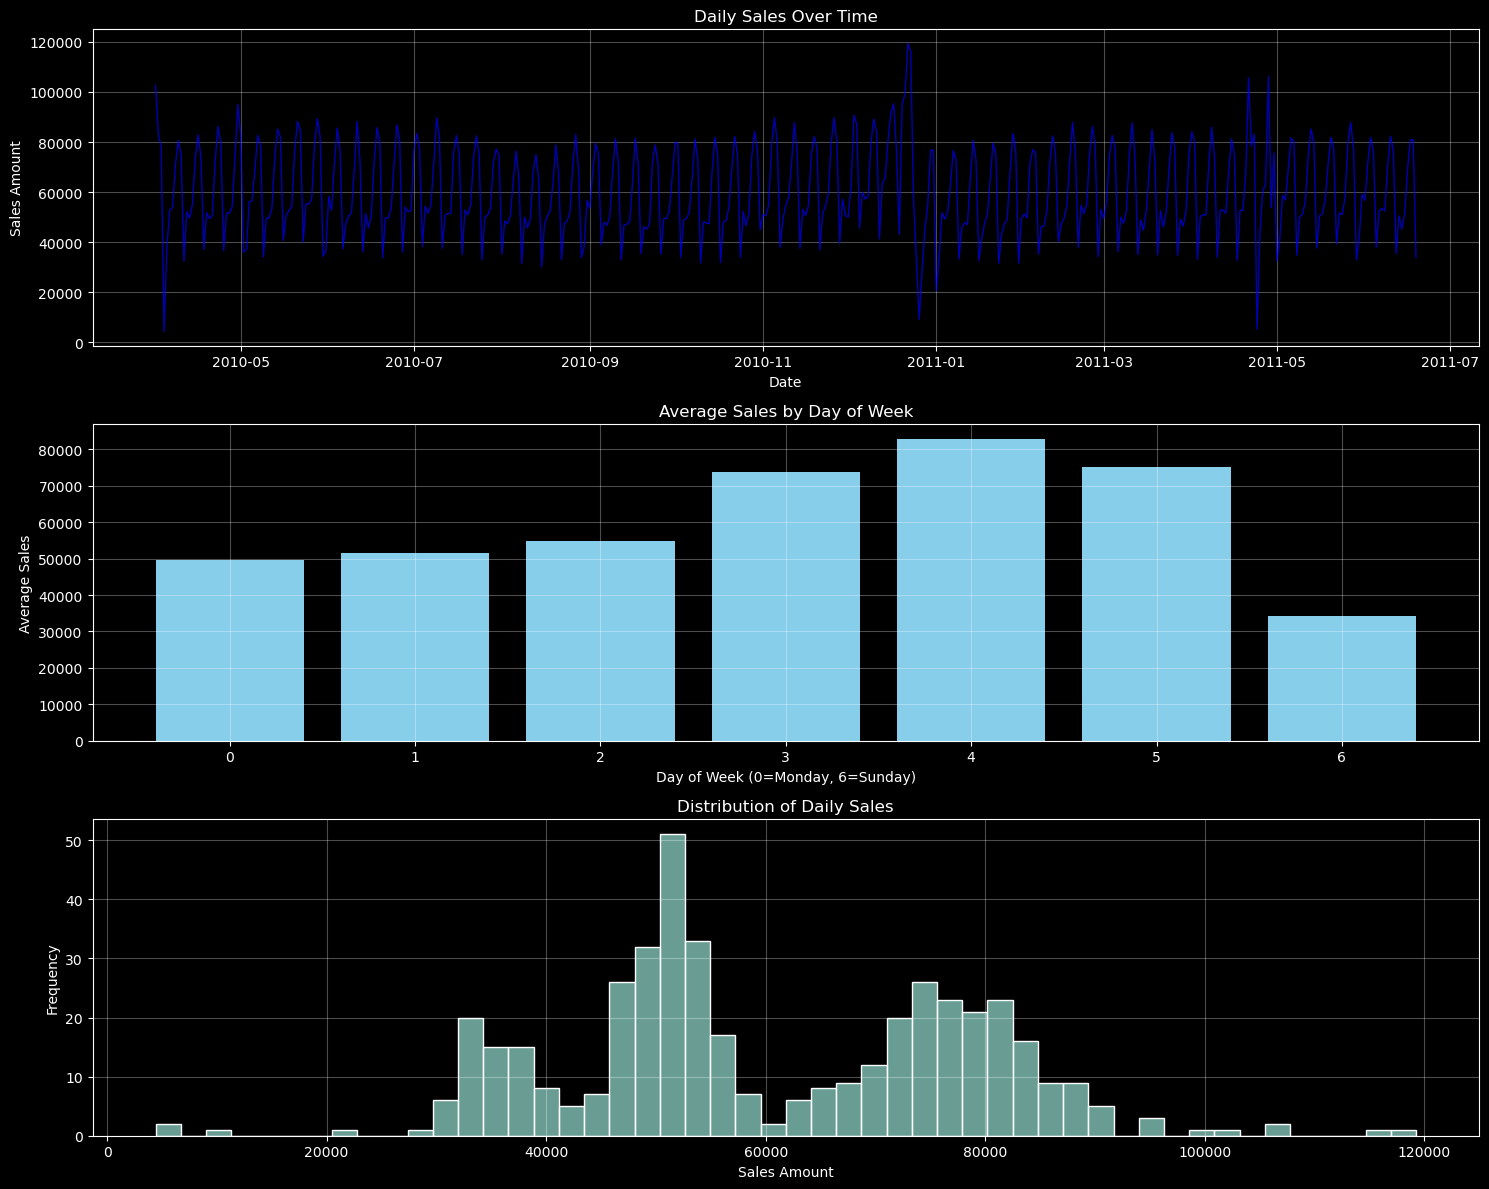

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))
fig.tight_layout(pad=4.0)

ax1.plot(daily_sales['visit_date'], daily_sales['visit_spend'],
         linewidth=1, color='blue', alpha=0.7)
ax1.set_title('Daily Sales Over Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Sales Amount')
ax1.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
ax1.grid(True, alpha=0.3)

weekly_avg = daily_sales.groupby('dayofweek')['visit_spend'].mean()
ax2.bar(weekly_avg.index, weekly_avg.values, color='skyblue')
ax2.set_title('Average Sales by Day of Week')
ax2.set_xlabel('Day of Week (0=Monday, 6=Sunday)')
ax2.set_ylabel('Average Sales')
ax2.grid(True, alpha=0.3)

sns.histplot(data=daily_sales, x='visit_spend', bins=50, ax=ax3)
ax3.set_title('Distribution of Daily Sales')
ax3.set_xlabel('Sales Amount')
ax3.set_ylabel('Frequency')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [156]:
print(daily_sales.head(20))

   visit_date  visit_spend  dayofweek
0  2010-04-01    102625.86          3
1  2010-04-02     82660.90          4
2  2010-04-03     78081.71          5
3  2010-04-04      4411.05          6
4  2010-04-05     38144.77          0
5  2010-04-06     52928.27          1
6  2010-04-07     53908.71          2
7  2010-04-08     70863.75          3
8  2010-04-09     80590.71          4
9  2010-04-10     75106.49          5
10 2010-04-11     32378.62          6
11 2010-04-12     52254.00          0
12 2010-04-13     49675.77          1
13 2010-04-14     55140.20          2
14 2010-04-15     73373.36          3
15 2010-04-16     82873.34          4
16 2010-04-17     73813.13          5
17 2010-04-18     37063.13          6
18 2010-04-19     51794.76          0
19 2010-04-20     49453.42          1


In [157]:
daily_sales['month'] = daily_sales['visit_date'].dt.month
daily_sales['day'] = daily_sales['visit_date'].dt.day

for i in [1, 2, 3, 4, 5, 6, 7, 14]:
    daily_sales[f'lag_{i}'] = daily_sales['visit_spend'].shift(i)

lag_correlations = daily_sales[[col for col in daily_sales.columns
                               if col.startswith('lag_')]].corrwith(daily_sales['visit_spend'])
print("\nCorrelations with target:")
print(lag_correlations.sort_values(ascending=False))

print(daily_sales.head(20))



Correlations with target:
lag_7     0.850419
lag_14    0.792866
lag_1     0.361515
lag_6     0.292833
lag_2    -0.169850
lag_5    -0.197490
lag_3    -0.440600
lag_4    -0.456537
dtype: float64
   visit_date  visit_spend  dayofweek  month  day      lag_1      lag_2  \
0  2010-04-01    102625.86          3      4    1        NaN        NaN   
1  2010-04-02     82660.90          4      4    2  102625.86        NaN   
2  2010-04-03     78081.71          5      4    3   82660.90  102625.86   
3  2010-04-04      4411.05          6      4    4   78081.71   82660.90   
4  2010-04-05     38144.77          0      4    5    4411.05   78081.71   
5  2010-04-06     52928.27          1      4    6   38144.77    4411.05   
6  2010-04-07     53908.71          2      4    7   52928.27   38144.77   
7  2010-04-08     70863.75          3      4    8   53908.71   52928.27   
8  2010-04-09     80590.71          4      4    9   70863.75   53908.71   
9  2010-04-10     75106.49          5      4   10   8059

Látható hogy a 14, 7 napos lagnak elég nagy korrelációja van a jelenlegi eladásokkal, mindez egy erős hetente ismétlődő mintát sugall (és persze a fentebbi plotok is).

# Baseline

Baseline Model Performance Metrics:
Mean Absolute Error: 6906.25
Mean Absolute Percentage Error: 17.31%

Weekly Average Performance:
            percentage_error
date                        
2011-03-27          2.530295
2011-04-03          4.052590
2011-04-10          4.156331
2011-04-17          6.197964
2011-04-24         89.797974


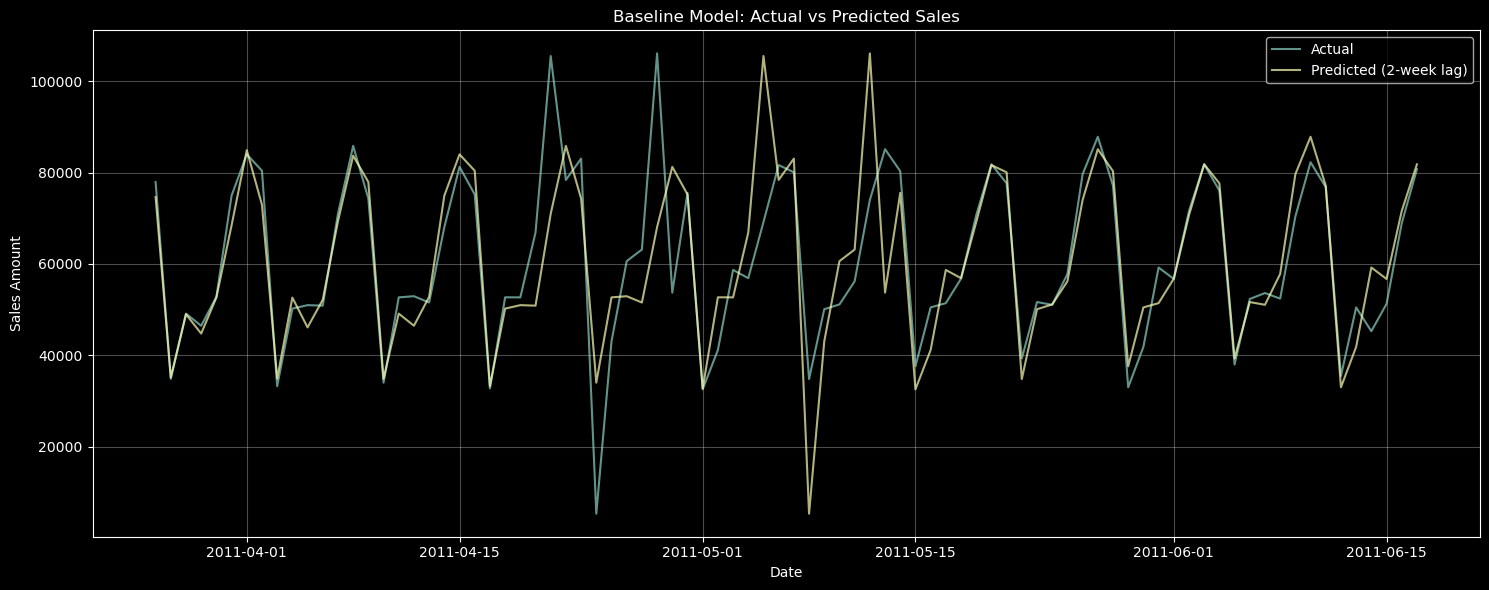

In [ ]:
def prepare_baseline_predictions(data, evaluation_start_date='2011-03-19'):
    evaluation_start = pd.to_datetime(evaluation_start_date)
    predictions = []
    actuals = []
    prediction_dates = []

    # find all fridays
    friday_dates = data[
        (data['visit_date'] >= evaluation_start) &
        (data['dayofweek'] == 4)
    ]['visit_date'].tolist()

    for friday in friday_dates:
        # saturday to friday
        next_week_dates = [
            friday + timedelta(days=i)
            for i in range(1, 8)
        ]

        next_week_actuals = data[
            data['visit_date'].isin(next_week_dates)
        ]['visit_spend'].tolist()

        # get lag_14 values for all dates
        next_week_predictions = data[
            data['visit_date'].isin(next_week_dates)
        ]['lag_14'].tolist()

        # just in case
        if len(next_week_actuals) == 7 and len(next_week_predictions) == 7:
            predictions.extend(next_week_predictions)
            actuals.extend(next_week_actuals)
            prediction_dates.extend(next_week_dates)

    results = pd.DataFrame({
        'date': prediction_dates,
        'actual': actuals,
        'predicted': predictions
    })

    # MAE & MAPE
    results['absolute_error'] = abs(results['actual'] - results['predicted'])
    results['percentage_error'] = (
        abs(results['actual'] - results['predicted']) / results['actual'] * 100
    )

    return results

baseline_results = prepare_baseline_predictions(daily_sales)
print("Baseline Model Performance Metrics:")
print(f"Mean Absolute Error: {baseline_results['absolute_error'].mean():.2f}")
print(f"Mean Absolute Percentage Error: {baseline_results['percentage_error'].mean():.2f}%")

weekly_performance = baseline_results.set_index('date').resample('W').mean()
print("\nWeekly Average Performance:")
print(weekly_performance[['percentage_error']].head())

plt.figure(figsize=(15, 6))
plt.plot(baseline_results['date'], baseline_results['actual'],
         label='Actual', alpha=0.7)
plt.plot(baseline_results['date'], baseline_results['predicted'],
         label='Predicted (2-week lag)', alpha=0.7)
plt.title('Baseline Model: Actual vs Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Prophet

20:41:07 - cmdstanpy - INFO - Chain [1] start processing
20:41:08 - cmdstanpy - INFO - Chain [1] done processing
20:41:08 - cmdstanpy - INFO - Chain [1] start processing
20:41:08 - cmdstanpy - INFO - Chain [1] done processing
20:41:08 - cmdstanpy - INFO - Chain [1] start processing
20:41:08 - cmdstanpy - INFO - Chain [1] done processing
20:41:08 - cmdstanpy - INFO - Chain [1] start processing
20:41:09 - cmdstanpy - INFO - Chain [1] done processing
20:41:09 - cmdstanpy - INFO - Chain [1] start processing
20:41:09 - cmdstanpy - INFO - Chain [1] done processing
20:41:09 - cmdstanpy - INFO - Chain [1] start processing
20:41:09 - cmdstanpy - INFO - Chain [1] done processing
20:41:09 - cmdstanpy - INFO - Chain [1] start processing
20:41:10 - cmdstanpy - INFO - Chain [1] done processing
20:41:10 - cmdstanpy - INFO - Chain [1] start processing
20:41:10 - cmdstanpy - INFO - Chain [1] done processing
20:41:10 - cmdstanpy - INFO - Chain [1] start processing
20:41:10 - cmdstanpy - INFO - Chain [1]

Prophet Model Performance Metrics:
Mean Absolute Error: 4859.36
Mean Absolute Percentage Error: 14.09%

Weekly Average Performance:
            percentage_error
date                        
2011-03-27         12.561890
2011-04-03          8.171188
2011-04-10          3.555981
2011-04-17          3.675982
2011-04-24         94.862164

Model Comparison:
Baseline MAPE: 17.31%
Prophet MAPE: 14.09%


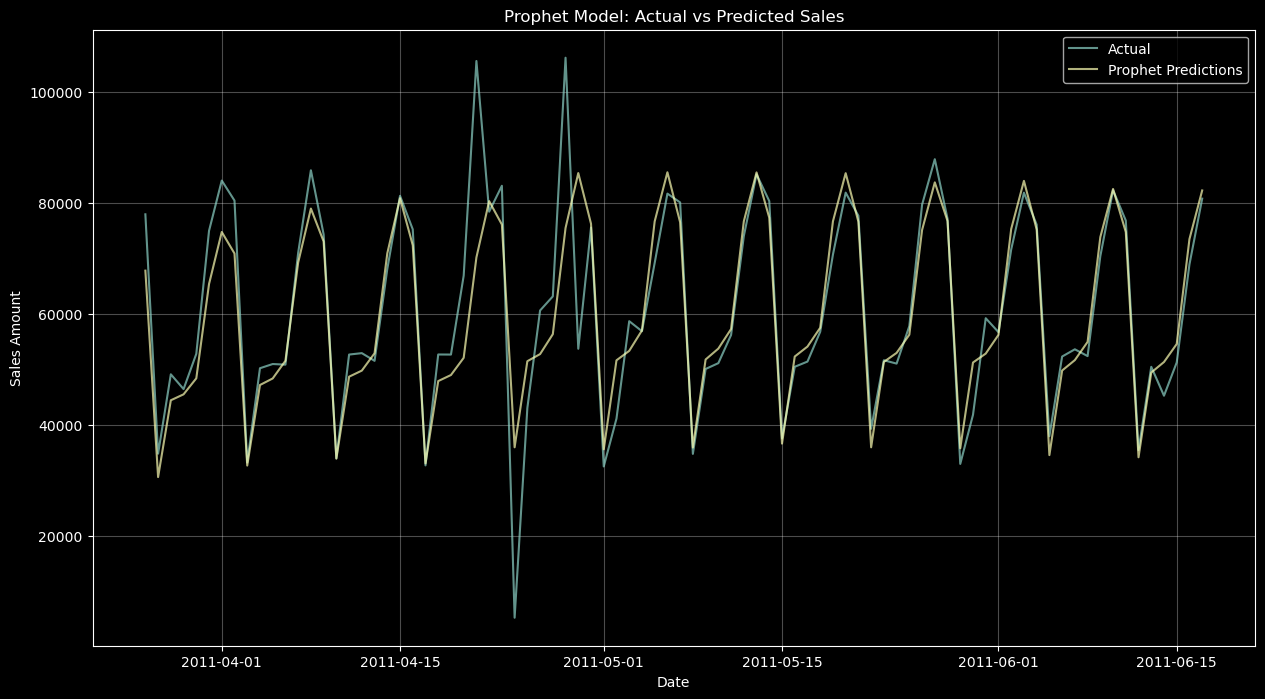

In [ ]:
def prepare_prophet_predictions(data, evaluation_start_date='2011-03-19'):
    evaluation_start = pd.to_datetime(evaluation_start_date)

    predictions = []
    actuals = []
    prediction_dates = []

    friday_dates = data[
        (data['visit_date'] >= evaluation_start) &
        (data['dayofweek'] == 4)
    ]['visit_date'].tolist()

    for friday in friday_dates:
        prophet_data = data[data['visit_date'] <= friday].copy()
        prophet_data = prophet_data.rename(columns={
            'visit_date': 'ds',
            'visit_spend': 'y'
        })

        model = Prophet(
            weekly_seasonality=True,
            daily_seasonality=False,
            yearly_seasonality=True,
            seasonality_mode='multiplicative'
        )
        model.fit(prophet_data)

        next_week_dates = [friday + timedelta(days=i) for i in range(1, 8)]
        future_dates = pd.DataFrame({'ds': next_week_dates})
        forecast = model.predict(future_dates)
        next_week_predictions = forecast['yhat'].tolist()

        next_week_actuals = data[
            data['visit_date'].isin(next_week_dates)
        ]['visit_spend'].tolist()

        if len(next_week_actuals) == 7 and len(next_week_predictions) == 7:
            predictions.extend(next_week_predictions)
            actuals.extend(next_week_actuals)
            prediction_dates.extend(next_week_dates)

    results = pd.DataFrame({
        'date': prediction_dates,
        'actual': actuals,
        'predicted': predictions
    })

    results['absolute_error'] = abs(results['actual'] - results['predicted'])
    results['percentage_error'] = (
        abs(results['actual'] - results['predicted']) / results['actual'] * 100
    )

    return results

prophet_results = prepare_prophet_predictions(daily_sales)
print("Prophet Model Performance Metrics:")
print(f"Mean Absolute Error: {prophet_results['absolute_error'].mean():.2f}")
print(f"Mean Absolute Percentage Error: {prophet_results['percentage_error'].mean():.2f}%")

weekly_performance = prophet_results.set_index('date').resample('W').mean()
print("\nWeekly Average Performance:")
print(weekly_performance[['percentage_error']].head())

print("\nModel Comparison:")
print("Baseline MAPE: {:.2f}%".format(baseline_results['percentage_error'].mean()))
print("Prophet MAPE: {:.2f}%".format(prophet_results['percentage_error'].mean()))

plt.figure(figsize=(15, 8))
plt.plot(prophet_results['date'], prophet_results['actual'],
         label='Actual', alpha=0.7)
plt.plot(prophet_results['date'], prophet_results['predicted'],
         label='Prophet Predictions', alpha=0.7)
plt.title('Prophet Model: Actual vs Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


20:41:12 - cmdstanpy - INFO - Chain [1] start processing
20:41:12 - cmdstanpy - INFO - Chain [1] done processing
20:41:12 - cmdstanpy - INFO - Chain [1] start processing
20:41:12 - cmdstanpy - INFO - Chain [1] done processing
20:41:13 - cmdstanpy - INFO - Chain [1] start processing
20:41:13 - cmdstanpy - INFO - Chain [1] done processing
20:41:13 - cmdstanpy - INFO - Chain [1] start processing
20:41:13 - cmdstanpy - INFO - Chain [1] done processing
20:41:13 - cmdstanpy - INFO - Chain [1] start processing
20:41:14 - cmdstanpy - INFO - Chain [1] done processing
20:41:14 - cmdstanpy - INFO - Chain [1] start processing
20:41:14 - cmdstanpy - INFO - Chain [1] done processing
20:41:14 - cmdstanpy - INFO - Chain [1] start processing
20:41:14 - cmdstanpy - INFO - Chain [1] done processing
20:41:15 - cmdstanpy - INFO - Chain [1] start processing
20:41:15 - cmdstanpy - INFO - Chain [1] done processing
20:41:15 - cmdstanpy - INFO - Chain [1] start processing
20:41:15 - cmdstanpy - INFO - Chain [1]

Tuned Prophet Model Performance Metrics:
Mean Absolute Error: 4392.12
Mean Absolute Percentage Error: 13.06%

Model Comparison:
Baseline MAPE: 17.31%
Original Prophet MAPE: 14.09%
Tuned Prophet MAPE: 13.06%


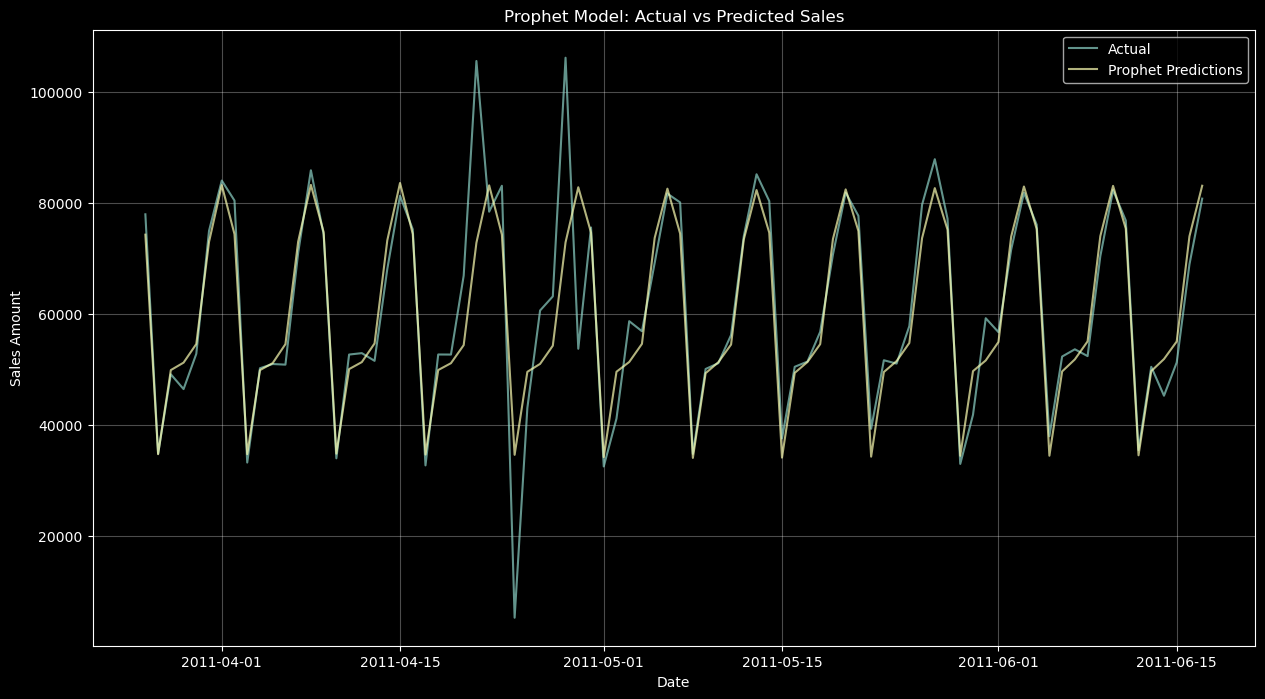

In [ ]:
def prepare_prophet_predictions_tuned(data, evaluation_start_date='2011-03-19'):
    evaluation_start = pd.to_datetime(evaluation_start_date)
    predictions = []
    actuals = []
    prediction_dates = []

    friday_dates = data[
        (data['visit_date'] >= evaluation_start) &
        (data['dayofweek'] == 4)
    ]['visit_date'].tolist()

    for friday in friday_dates:
        # prophet bs it needs it in this format for some reason
        prophet_data = data[data['visit_date'] <= friday].copy()
        prophet_data = prophet_data.rename(columns={
            'visit_date': 'ds',
            'visit_spend': 'y'
        })

        model = Prophet(
            changepoint_prior_scale=0.05,
            changepoint_range=0.88,

            # no effect warum?
            weekly_seasonality=20,
            seasonality_mode='multiplicative',

            holidays=get_holidays()
        )

        model.add_seasonality(
            name='weekly_pattern',
            period=7,
            fourier_order=5,
            prior_scale=20
        )

        model.fit(prophet_data)
        next_week_dates = [friday + timedelta(days=i) for i in range(1, 8)]
        future_dates = pd.DataFrame({'ds': next_week_dates})

        forecast = model.predict(future_dates)
        next_week_predictions = forecast['yhat'].tolist()

        next_week_actuals = data[
            data['visit_date'].isin(next_week_dates)
        ]['visit_spend'].tolist()

        if len(next_week_actuals) == 7 and len(next_week_predictions) == 7:
            predictions.extend(next_week_predictions)
            actuals.extend(next_week_actuals)
            prediction_dates.extend(next_week_dates)

    results = pd.DataFrame({
        'date': prediction_dates,
        'actual': actuals,
        'predicted': predictions
    })

    results['absolute_error'] = abs(results['actual'] - results['predicted'])
    results['percentage_error'] = (
        abs(results['actual'] - results['predicted']) / results['actual'] * 100
    )

    return results

def get_holidays():
    holidays = pd.DataFrame({
        'holiday': 'hun_holiday',
        'ds': pd.to_datetime([
            '2011-04-18',  # idk
            '2011-04-20',  # Easter
            '2011-04-21'   # Easter Monday
        ]),
        'lower_window': -1,
        'upper_window': 1,
    })
    return holidays


prophet_results_tuned = prepare_prophet_predictions_tuned(daily_sales)
print("Tuned Prophet Model Performance Metrics:")
print(f"Mean Absolute Error: {prophet_results_tuned['absolute_error'].mean():.2f}")
print(f"Mean Absolute Percentage Error: {prophet_results_tuned['percentage_error'].mean():.2f}%")

# all models
print("\nModel Comparison:")
print("Baseline MAPE: {:.2f}%".format(baseline_results['percentage_error'].mean()))
print("Original Prophet MAPE: {:.2f}%".format(prophet_results['percentage_error'].mean()))
print("Tuned Prophet MAPE: {:.2f}%".format(prophet_results_tuned['percentage_error'].mean()))


plt.figure(figsize=(15, 8))
plt.plot(prophet_results_tuned['date'], prophet_results_tuned['actual'],
         label='Actual', alpha=0.7)
plt.plot(prophet_results_tuned['date'], prophet_results_tuned['predicted'],
         label='Prophet Predictions', alpha=0.7)
plt.title('Prophet Model: Actual vs Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


A finetunolt verzióval és az eredetivel is megugorjuk a baseline modellt, ez már valami! :)

# ARIMA/SARIMA

Finding optimal SARIMA parameters...
Optimal SARIMA parameters - SARIMA(1, 0, 4)(1, 1, 1, 7)

SARIMA Model Performance Metrics:
Mean Absolute Error: 5398.27
Mean Absolute Percentage Error: 13.91%

Final Model Comparison:
Baseline MAPE: 17.31%
Prophet MAPE: 14.09%
Tuned Prophet MAPE: 13.06%
SARIMA MAPE: 13.91%


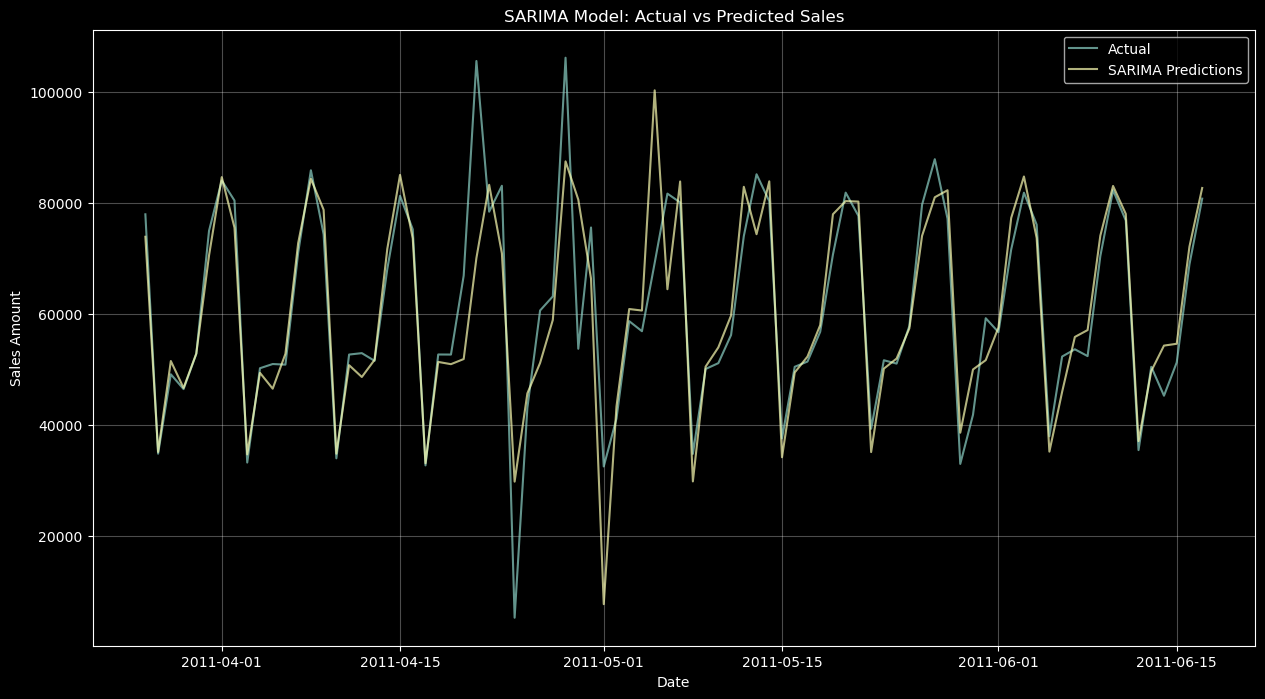

In [ ]:
warnings.filterwarnings('ignore')

def prepare_sarima_predictions(data, evaluation_start_date='2011-03-19'):
    evaluation_start = pd.to_datetime(evaluation_start_date)
    predictions = []
    actuals = []
    prediction_dates = []

    initial_data = data[data['visit_date'] < evaluation_start].copy()
    initial_data = initial_data.set_index('visit_date')['visit_spend']
    print("Finding optimal SARIMA parameters...")
    auto_model = auto_arima(initial_data,
                           seasonal=True,
                           m=7,
                           D=1,
                           max_p=5, max_q=5,
                           max_P=3, max_Q=3,
                           stepwise=True,
                           suppress_warnings=True)

    order = auto_model.order
    seasonal_order = auto_model.seasonal_order
    print(f"Optimal SARIMA parameters - SARIMA{order}{seasonal_order}")

    friday_dates = data[
        (data['visit_date'] >= evaluation_start) &
        (data['dayofweek'] == 4)
    ]['visit_date'].tolist()

    for friday in friday_dates:
        train_data = data[data['visit_date'] <= friday].copy()
        train_data = train_data.set_index('visit_date')['visit_spend']

        model = SARIMAX(train_data,
                       order=order,
                       seasonal_order=seasonal_order,
                       enforce_stationarity=False,
                       enforce_invertibility=False)

        fitted_model = model.fit(disp=False)

        next_week_dates = [friday + timedelta(days=i) for i in range(1, 8)]
        forecast = fitted_model.forecast(steps=7)
        next_week_predictions = forecast.tolist()

        next_week_actuals = data[
            data['visit_date'].isin(next_week_dates)
        ]['visit_spend'].tolist()

        if len(next_week_actuals) == 7 and len(next_week_predictions) == 7:
            predictions.extend(next_week_predictions)
            actuals.extend(next_week_actuals)
            prediction_dates.extend(next_week_dates)

    results = pd.DataFrame({
        'date': prediction_dates,
        'actual': actuals,
        'predicted': predictions
    })

    results['absolute_error'] = abs(results['actual'] - results['predicted'])
    results['percentage_error'] = (
        abs(results['actual'] - results['predicted']) / results['actual'] * 100
    )

    return results

sarima_results = prepare_sarima_predictions(daily_sales)

print("\nSARIMA Model Performance Metrics:")
print(f"Mean Absolute Error: {sarima_results['absolute_error'].mean():.2f}")
print(f"Mean Absolute Percentage Error: {sarima_results['percentage_error'].mean():.2f}%")

print("\nFinal Model Comparison:")
print("Baseline MAPE: {:.2f}%".format(baseline_results['percentage_error'].mean()))
print("Prophet MAPE: {:.2f}%".format(prophet_results['percentage_error'].mean()))
print("Tuned Prophet MAPE: {:.2f}%".format(prophet_results_tuned['percentage_error'].mean()))
print("SARIMA MAPE: {:.2f}%".format(sarima_results['percentage_error'].mean()))

plt.figure(figsize=(15, 8))
plt.plot(sarima_results['date'], sarima_results['actual'],
         label='Actual', alpha=0.7)
plt.plot(sarima_results['date'], sarima_results['predicted'],
         label='SARIMA Predictions', alpha=0.7)
plt.title('SARIMA Model: Actual vs Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

auto_arima-t használva végigiteráltunk pár lehetséges paraméteren, és ezzel is egy jobb MAPE-t értünk el mint a baseline modell.